## Homework 02-2: due 2024/04/08 23:59 (70%)

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength. In this part, please predict the **strength of concrete**.

In [1]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
# For reproduce the result
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

### 1. Define the model and dataset (10%)

#### 1.1 Please follow the Step 2 from the tutorial to create a class ***ConcreteDataset*** to load the data you need and also do the ***Min-Max scaling*** to the ***feature and label***. (5%)

In [3]:
#for min-max scaling
scaler_feature = MinMaxScaler()
scaler_label = MinMaxScaler()

class ConcreteDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        if csv_path == 'data/train.csv':
            #fit the scaler on training set
            scaled_label = scaler_label.fit_transform(df['csMPa'].values.reshape(-1,1))
            df.drop('csMPa', axis = 1, inplace=True)
            scaled_feature = scaler_feature.fit_transform(df)
        else:
            #use the scaler that has been fitted on the training dataset
            scaled_label = scaler_label.transform(df['csMPa'].values.reshape(-1,1))
            df.drop('csMPa', axis = 1, inplace=True)
            scaled_feature = scaler_feature.transform(df)
        
        self.y = torch.tensor(scaled_label)
        self.X = torch.tensor(scaled_feature)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

#### 1.2 By following the tutorial, try to create a class ***MLP(Neural Network)*** with ***three hidden layers*** as your network architecture. Also, for the convenience of implementation, please set the numbers of hidden nodes and the activation functions as input variables to the forward functions.(5%) 

In [4]:
#instead of setting the no of hidden nodes and the activations functions as input variables
#to the forward function, I pass it to the constructor
class MLP(nn.Module):
    def __init__(self, n1, n2, n3, h_activation, o_activation):
        super(MLP, self).__init__()
        
        #no of features in the dataset is 8 initially
        self.linear1 = nn.Linear(8, n1, dtype=torch.float64)
        self.act1 = h_activation()
        self.linear2 = nn.Linear(n1, n2, dtype=torch.float64)
        self.act2 = h_activation()
        self.linear3 = nn.Linear(n2, n3, dtype=torch.float64) 
        self.act3 = h_activation()
        self.linear4 = nn.Linear(n3, 1, dtype=torch.float64)
        self.output_act = o_activation()
        
    def forward(self, X):
        X = self.linear1(X)
        X = self.act1(X)
        X = self.linear2(X)
        X = self.act2(X)
        X = self.linear3(X)
        X = self.act3(X)
        X = self.linear4(X)
        X = self.output_act(X)
        return X
      

### 2. Train the model (60%)

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not. (5%)

In [5]:
train = ConcreteDataset('data/train.csv')
validation = ConcreteDataset('data/validation.csv')

#shuffle for train
train_dl = DataLoader(train, batch_size= 64, shuffle=True)
#no need to shuffle for validation
validation_dl = DataLoader(validation, batch_size= 64, shuffle=False)


#### 2.2 Create two MLP model from the table below and ***print the model*** (10%):
| | Hidden Layer 1| Hidden Layer 2| Hidden Layer 3| Activation in each hidden nodes | Activation for output |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model1***| 64 | 16 | 8 | Tanh | Identity |

In [6]:
#(originalLen, n1, n2, n3, h_activation, o_activation)

#Model 1
model1 = MLP(256, 64, 8, nn.Tanh, nn.Tanh)

#Model 2
model2 = MLP(64, 16, 8, nn.Tanh, nn.Identity)

print(model1)
print(model2)


MLP(
  (linear1): Linear(in_features=8, out_features=256, bias=True)
  (act1): Tanh()
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (act2): Tanh()
  (linear3): Linear(in_features=64, out_features=8, bias=True)
  (act3): Tanh()
  (linear4): Linear(in_features=8, out_features=1, bias=True)
  (output_act): Tanh()
)
MLP(
  (linear1): Linear(in_features=8, out_features=64, bias=True)
  (act1): Tanh()
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (act2): Tanh()
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (act3): Tanh()
  (linear4): Linear(in_features=8, out_features=1, bias=True)
  (output_act): Identity()
)


#### 2.3 Train the above two models with the same hyperpameters below and do the validation in every epoch. Choose the appropriate type of loss function according to the task. (25%)
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 300 | SGD | 0.9 |

In [7]:
#since it is regression, the criterion will be MSE

def train_model(model, n_epoch):
    train_loss = []
    validation_loss = []
    
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)
    
    for epoch in range(n_epoch):
        model.train()
        total_loss = 0
        for input, target in train_dl:
            optimizer.zero_grad()
            pred = model(input)
            loss = criterion(pred, target)
            total_loss += loss
            loss.backward()
            optimizer.step()
        #loss per epoch = total loss / no of batches
        total_loss /= len(train_dl)
        train_loss.append(total_loss.item())
        #validation
        model.eval()
        total_loss = 0
        for input, target in validation_dl:
            pred = model(input)
            loss = criterion(pred, target)
            total_loss += loss
        total_loss /= len(validation_dl)
        validation_loss.append(total_loss.item())
        
    return (train_loss, validation_loss)


In [8]:
#train the model with epoch 300
model1_loss = train_model(model1, 300)
model2_loss = train_model(model2, 300)

#### 2.4 Please include the plot that shows how the training/validation loss vary with the training epoch. Show the plots using the above two models and write down the observation. (5%)

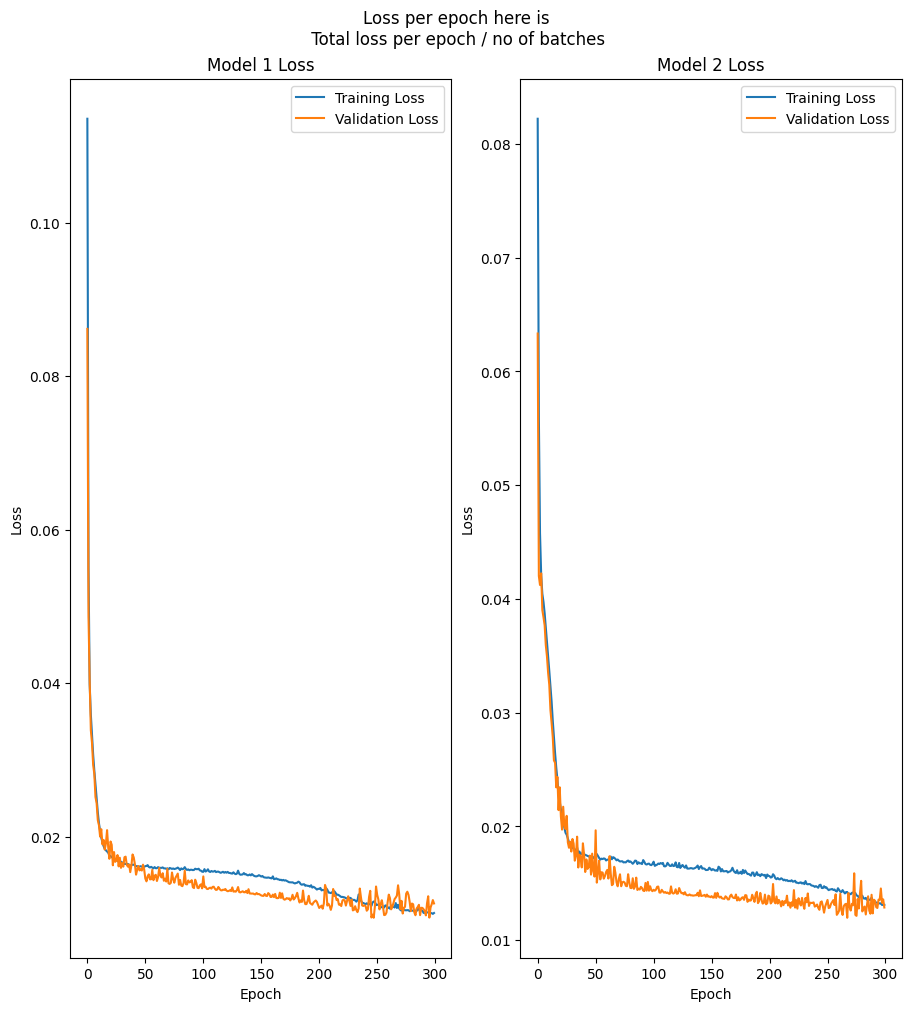

In [9]:
def draw_plot(n_epoch):    
    fig, ax = plt.subplots(1,2, figsize= (9,10), constrained_layout = True)

    x_axis = np.arange(n_epoch)
    fig.suptitle("Loss per epoch here is\n Total loss per epoch / no of batches")
    #model 1
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Model 1 Loss')

    ax[0].plot(x_axis, model1_loss[0], label='Training Loss')
    ax[0].plot(x_axis, model1_loss[1], label='Validation Loss')

    ax[0].legend()


    #model 2
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Model 2 Loss')

    ax[1].plot(x_axis, model2_loss[0], label='Training Loss')
    ax[1].plot(x_axis, model2_loss[1], label='Validation Loss')

    ax[1].legend()

draw_plot(300)

### Observation
For both models, after around 200 epoch, the validation loss started to become unstable (flunctuates more) and slowly increasing.
On the other hand, the training loss keep decreasing. This shows that after 200 epoch, overfitting is happening.

So, I will be picking an epoch of 200 for the next question.


#### 2.5 From the observation of the previous question, please determine an appropriate epoch and retrain the two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***. (10%)
##### (Note. You should reload the models and the optimizer, otherwise, you will resume from the previous stop.)

In [10]:
#Retrain model up to epoch 200
#Model 1
model1_epoch200 = MLP(256, 64, 8, nn.Tanh, nn.Tanh)

#Model 2
model2_epoch200 = MLP(64, 16, 8, nn.Tanh, nn.Identity)


#train
model1_loss = train_model(model1_epoch200, 200)
model2_loss = train_model(model2_epoch200, 200)

#save model
torch.save(model1_epoch200.state_dict(), 'model1.pth')
torch.save(model2_epoch200.state_dict(), 'model2.pth')


#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, make a dataframe with target and prediction like below and save it as ***regression.csv*** (5%)
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [11]:
#load the models
loaded_model1 = MLP(256, 64, 8, nn.Tanh, nn.Tanh)
loaded_model1.load_state_dict(torch.load('model1.pth'))

loaded_model2 = MLP(64, 16, 8, nn.Tanh, nn.Identity)
loaded_model2.load_state_dict(torch.load('model2.pth'))

<All keys matched successfully>

In [25]:
#testing the model and creating the table

test_df = pd.read_csv('data/test.csv')
final_table = pd.DataFrame()
final_table['Target'] = test_df['csMPa']

#apply min max scaling cuz we do that for our training dataset
#y test no need to be scaled since I will calculate the MSE with no scaling
y_test = torch.tensor(test_df['csMPa']).reshape(-1,1)
#drop the label from the dataframe
test_df.drop('csMPa', axis=1, inplace=True)
#scaled the feature
X_test = torch.from_numpy(scaler_feature.transform(test_df))

test_loss = []

def test_model(model):
    model.eval()
    criterion = nn.MSELoss()
    pred = model(X_test)
    
    
    #for MSE, I will calculate it WITHOUT SCALING
    #since we scale the features before, and train the model with scaled features, we need to do inverse scaling for the label
    noScale_pred = torch.from_numpy(scaler_label.inverse_transform(pred.detach().numpy()))
    noScale_loss = criterion(noScale_pred, y_test)
    test_loss.append(noScale_loss)
    return noScale_pred


model1_pred = test_model(loaded_model1)
model2_pred = test_model(loaded_model2)

print('Before printing MSE, I made sure to scale back the prediction label to its original form')
print('The MSE of model 1 is:', test_loss[0].item())
print('The MSE of model 2 is:', test_loss[1].item())

#save the predictions to the dataframe
final_table['Model 1'] = model1_pred
final_table['Model 2'] = model2_pred

final_table.to_csv('regression.csv', index=False)


Before printing MSE, I made sure to scale back the prediction label to its original form
The MSE of model 1 is: 69.56617941085868
The MSE of model 2 is: 84.18367768826324
